# MSE 546 Project
### Bank Customer Churn Prediction 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.metrics import make_scorer, classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, cross_validate

from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from imblearn.pipeline import Pipeline as imbpipeline
from imblearn.pipeline import make_pipeline

from lightgbm import LGBMClassifier
import xgboost as xgb
from xgboost import XGBClassifier

# load data

In [2]:
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

print(df_train.shape)
print(df_test.shape)

df_train.head(5)

(165034, 14)
(110023, 13)


,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


# EDA

plot correlation matrix to see if there's any multicolinearity between features

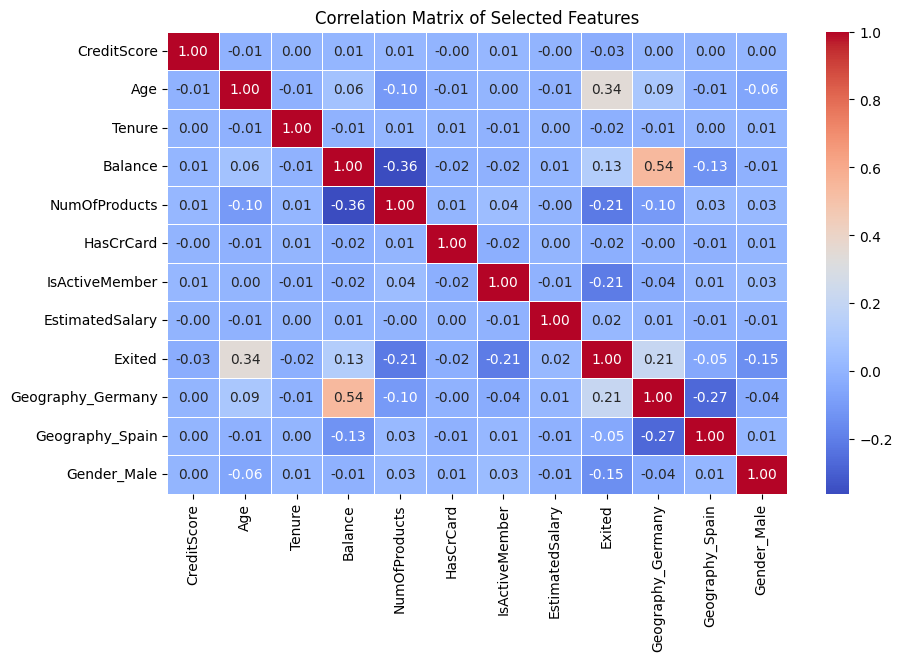

In [3]:
features = [
    "CreditScore", 
    "Geography", 
    "Gender", 
    "Age", 
    "Tenure", 
    "Balance", 
    "NumOfProducts", 
    "HasCrCard", 
    "IsActiveMember", 
    "EstimatedSalary",
      "Exited"
]

df_encoded = pd.get_dummies(df_train[features], drop_first=True)
corr_matrix = df_encoded.corr()
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Selected Features")
plt.show()

boxplot of all features to compare Exited customers to non Exited.

Inisghts:
- customers Exited are older on average

['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited']


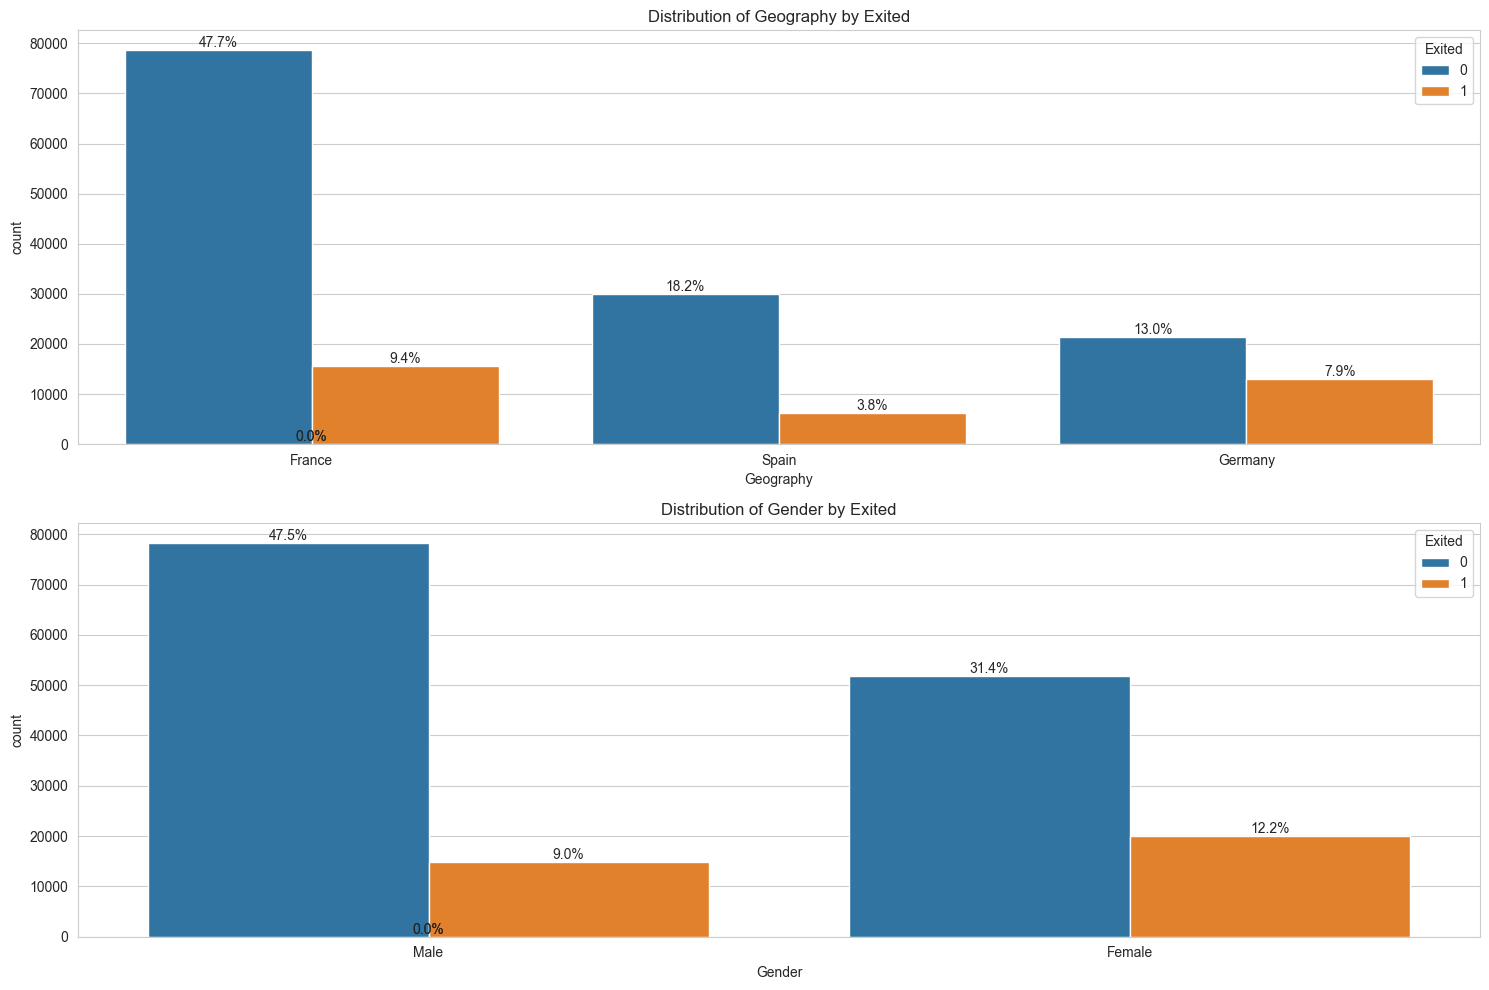

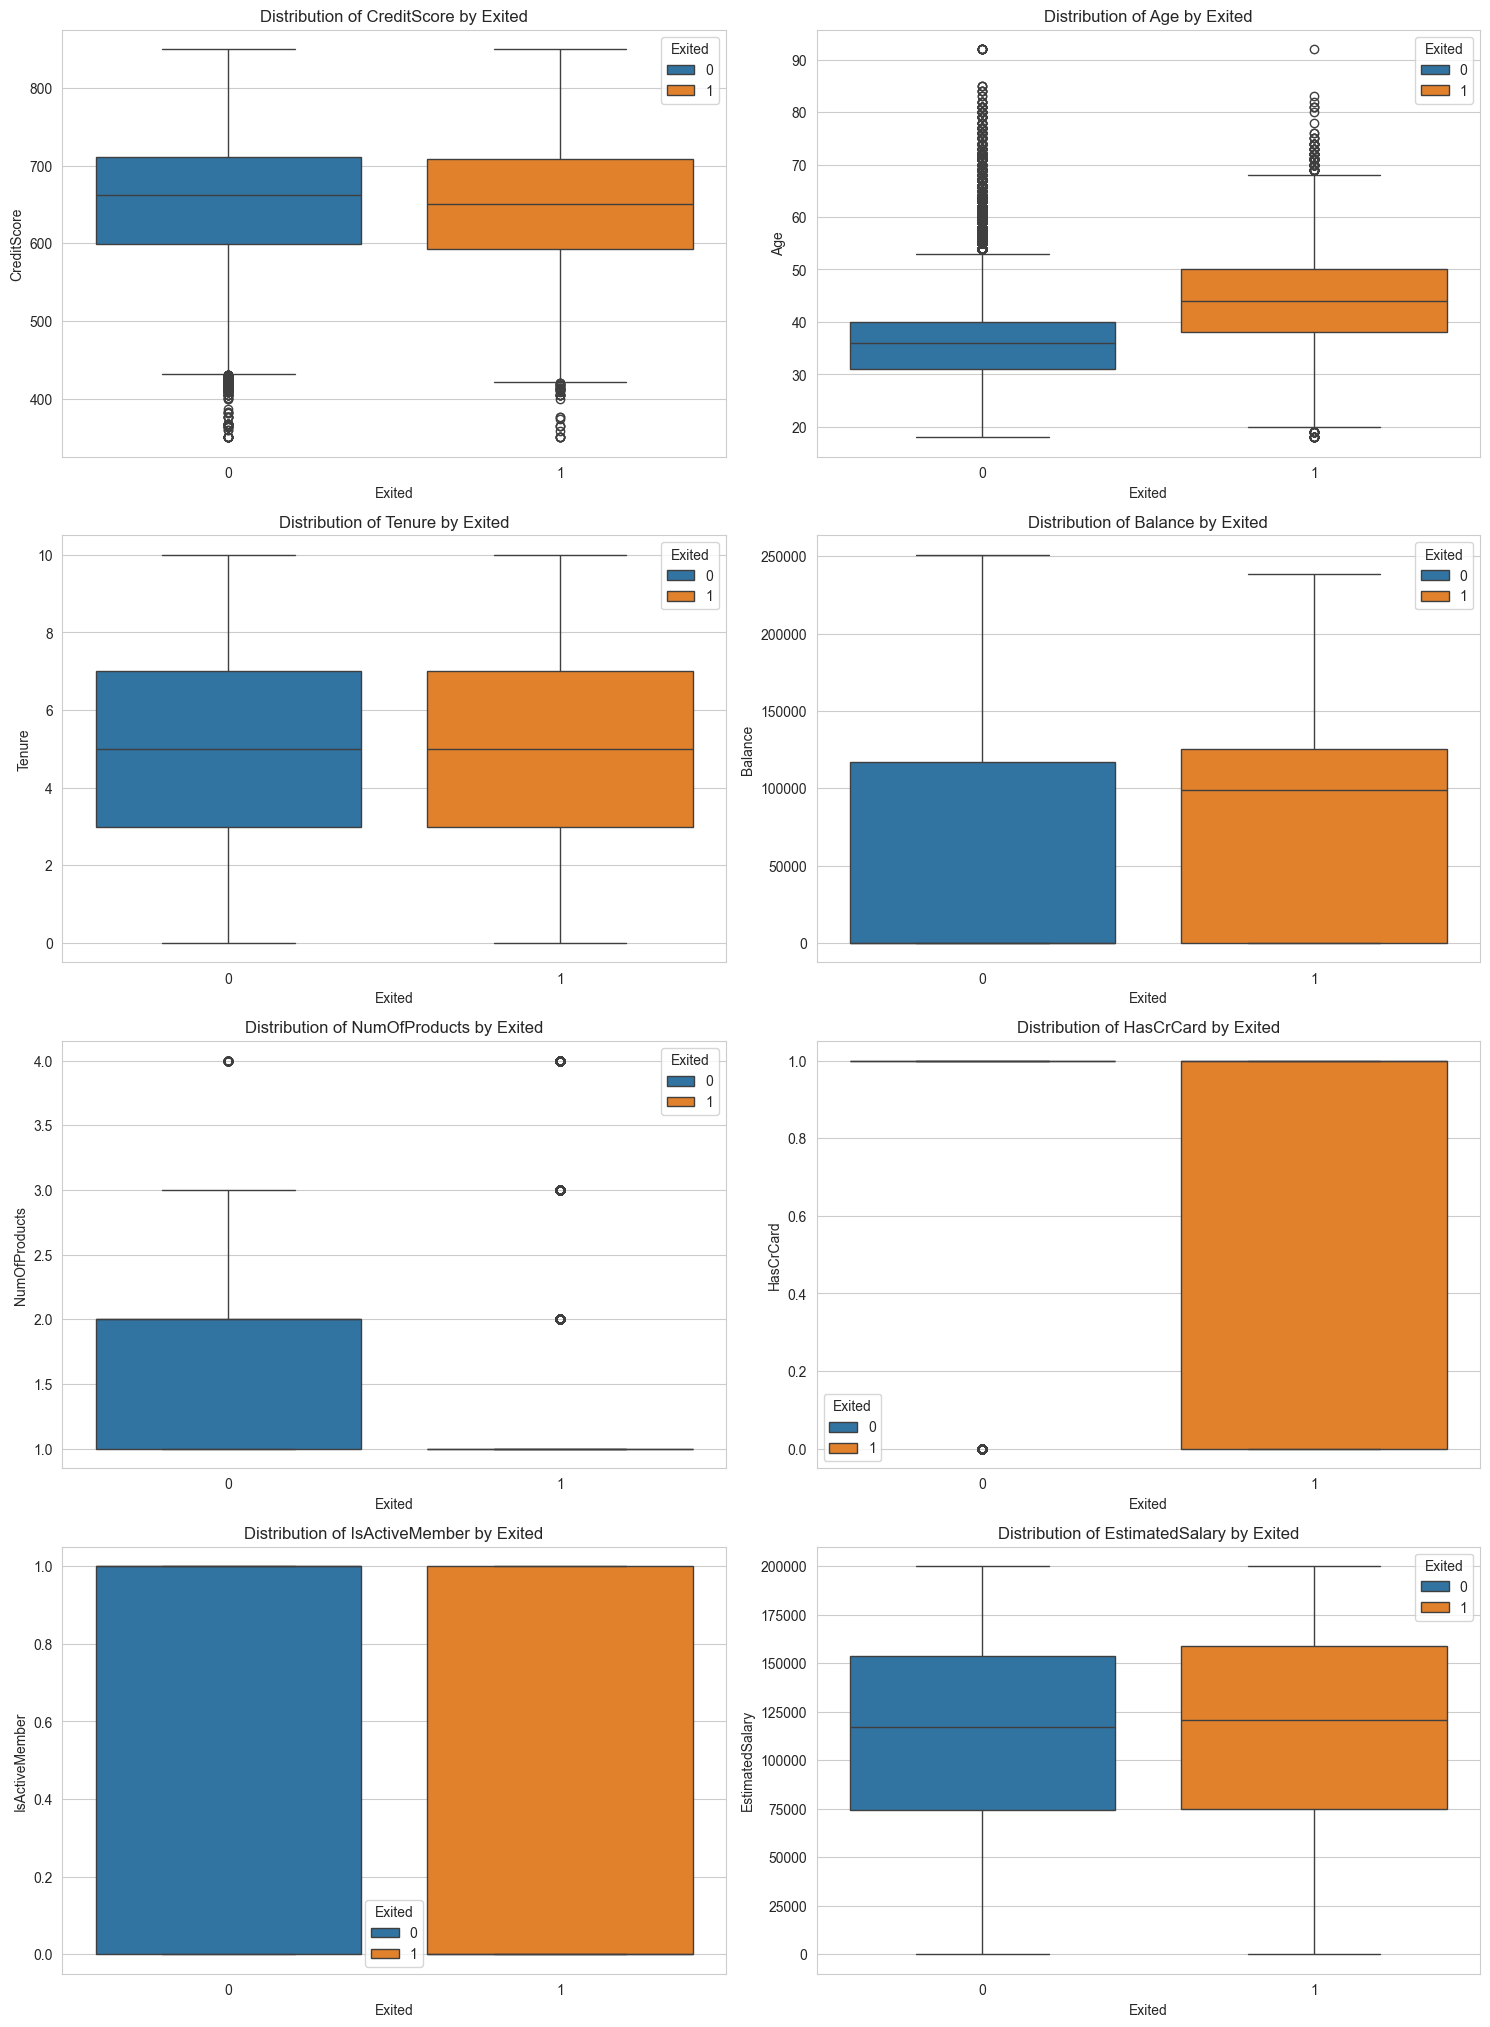

In [4]:
exclude_columns = ['CustomerId', 'id', 'Surname'] 
feature_columns = [col for col in df_train.columns if col not in exclude_columns]
print(feature_columns)
categorical_features = df_train[feature_columns].select_dtypes(include=['object', 'category']).columns.tolist()
numerical_features = df_train[feature_columns].select_dtypes(include=['int64', 'float64']).columns.tolist()

sns.set_style("whitegrid")
plt.figure(figsize=(15, 5 * len(categorical_features))) 

for i, col in enumerate(categorical_features, 1):
    plt.subplot(len(categorical_features), 1, i)
    
    ax = sns.countplot(data=df_train[feature_columns], x=col, hue='Exited')
    plt.title(f"Distribution of {col} by {'Exited'}")
    
    for p in ax.patches:
        height = p.get_height() 
        total = len(df_train[feature_columns])
        percentage = (height / total) * 100 
        ax.annotate(f'{percentage:.1f}%',
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='center', 
                    xytext=(0, 5),
                    textcoords='offset points')
    
plt.tight_layout()
plt.show()

num_cols = 2
num_rows = (len(numerical_features) // num_cols + 1)

plt.figure(figsize=(15, 5 * num_rows))

for i, col in enumerate(numerical_features, 1):
    if col != 'Exited':
        plt.subplot(num_rows, num_cols, i)
        sns.boxplot(data=df_train[feature_columns], x='Exited', y=col,  hue='Exited')
        plt.title(f"Distribution of {col} by {'Exited'}")
plt.tight_layout()
plt.show()

# class imbalance

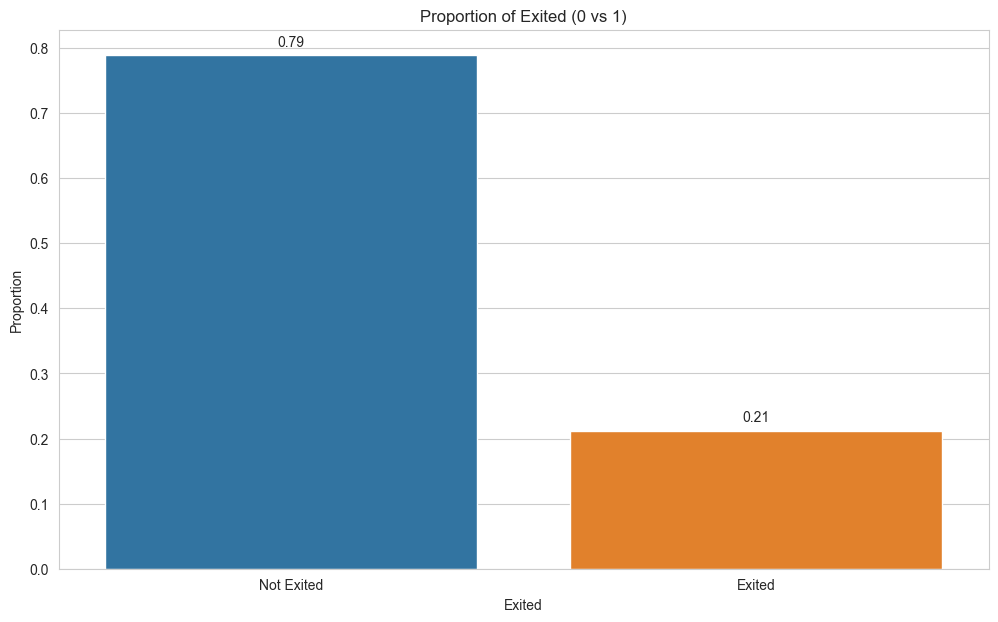

In [5]:
exited_proportion = df_train['Exited'].value_counts(normalize=True)

plt.figure(figsize=(12, 7))
ax = sns.barplot(x=exited_proportion.index, y=exited_proportion.values, hue=exited_proportion.index, legend=False)
plt.title('Proportion of Exited (0 vs 1)')
plt.xlabel('Exited')
plt.ylabel('Proportion')
plt.xticks([0, 1], ['Not Exited', 'Exited'])

for i, proportion in enumerate(exited_proportion.values):
    ax.text(i, proportion + 0.01, f'{proportion:.2f}', ha='center', va='bottom')

plt.show()

# data cleaning

In [6]:
def clean(df):
    df = df.dropna()
    df = df.drop_duplicates()
    return df

df_train = clean(df_train)
df_test = clean(df_test)
print(df_train.shape)

(165034, 14)


# data preparation

here we are performing the 80%/20% train test split on our df_train dataframe since we only have 'Exited' labels on the train.csv. The test.csv data does not have 'Exited' flag, but instead will be submitted to the Kaggle competition to see model performance.

The scikit learn pipeline allows us to perform our data preprocessing on our numeric and categorical variables consistently for all of our models.

- numeric features: will be scaled.

    - numeric features include:
['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']

- categorical variables will be one hot encoded.

    - categorical features include:
['Geography', 'Gender']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    df_train.drop(columns=['id', 'CustomerId', 'Surname', 'Exited']),
    df_train['Exited'],
    test_size=0.2,
    random_state=42
)

num_features = X_train.select_dtypes(include=['int64', 'float64', 'boolean']).columns.tolist()
cat_features = X_train.select_dtypes(include=['object']).columns.tolist()

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='if_binary'))
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_features),
    ('cat', cat_pipeline, cat_features),
])

X_train_preprocessed = preprocessor.fit_transform(X_train)

# cross validation code

here we have code that will be applied to the models to evaulate the generalizability

we're using stratified sampling since we have imbalanced classes. This will help to ensure that each of our partitions will have around the same proportion of each class. (i.e., we won't get a partition with all the majority class 'Exited' = 0)

In [8]:
def perform_x_validation(model, folds=5):
    scoring = {
        'accuracy': make_scorer(accuracy_score),
        'precision': make_scorer(precision_score, average='weighted'),
        'recall': make_scorer(recall_score, average='weighted'),
        'f1_score': make_scorer(f1_score, average='weighted')
    }
    kfold = StratifiedKFold(n_splits=folds, shuffle=True, random_state=42)
    results = cross_validate(model, X_train, y_train, cv=kfold, scoring=scoring, return_train_score=False)

    print("Metrics for each fold:")
    for i in range(kfold.get_n_splits()):
        print(f"\nFold {i + 1}:")
        print(f"  Accuracy: {results['test_accuracy'][i]:.4f}")
        print(f"  Precision: {results['test_precision'][i]:.4f}")
        print(f"  Recall: {results['test_recall'][i]:.4f}")
        print(f"  F1 Score: {results['test_f1_score'][i]:.4f}")

    print("\nMean metrics across all folds:")
    print(f"Accuracy: {results['test_accuracy'].mean():.4f}")
    print(f"Precision: {results['test_precision'].mean():.4f}")
    print(f"Recall: {results['test_recall'].mean():.4f}")
    print(f"F1 Score: {results['test_f1_score'].mean():.4f}")

# universal model evaluation code

this code will be used to evaulate our models to do the model selection process.

includes key metrics like Accuracy, precision, recall, F1 score, and AUC (most important)

we will also plot a confusion matrix to view the models predictions compared to actual churn

In [9]:
def evaluate_model(model, X_test, y_test, threshold=0.5):
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    y_pred_custom = (y_pred_proba >= threshold).astype(int)

    print("Accuracy:", accuracy_score(y_test, y_pred_custom))
    print(classification_report(y_test, y_pred_custom))

    precision = precision_score(y_test, y_pred_custom)
    recall = recall_score(y_test, y_pred_custom)
    f1 = f1_score(y_test, y_pred_custom)
    auc = roc_auc_score(y_test, y_pred_proba)

    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC: {auc:.4f}")

    cm = confusion_matrix(y_test, y_pred_custom)

    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_percent, annot=True, fmt='.2f', cmap='Blues', cbar=False, 
                xticklabels=['Predicted Not Churn', 'Predicted Churn'], 
                yticklabels=['Actual Not Churn', 'Actual Churn'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix (Percentage)')
    plt.show()

# logistic regression

logistic will act as our baseline model.

Accuracy: 0.751537552640349
              precision    recall  f1-score   support

           0       0.92      0.75      0.83     26052
           1       0.45      0.74      0.56      6955

    accuracy                           0.75     33007
   macro avg       0.68      0.75      0.69     33007
weighted avg       0.82      0.75      0.77     33007

Precision: 0.4460
Recall: 0.7403
F1 Score: 0.5567
AUC: 0.8193


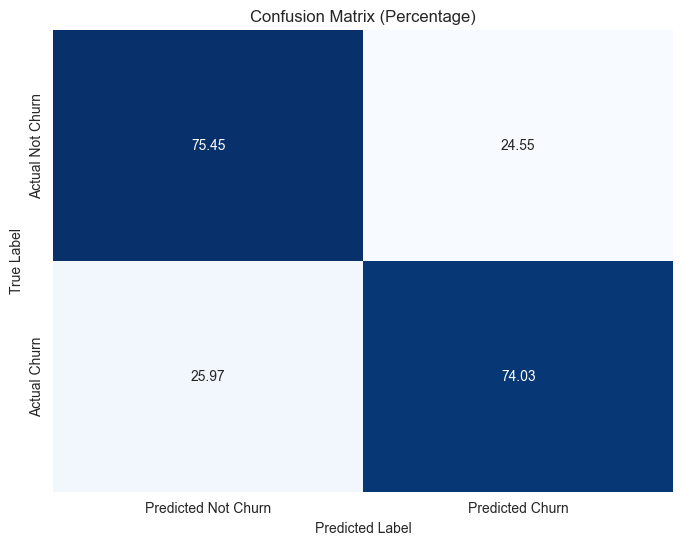

Metrics for each fold:

Fold 1:
  Accuracy: 0.7584
  Precision: 0.8209
  Recall: 0.7584
  F1 Score: 0.7763

Fold 2:
  Accuracy: 0.7530
  Precision: 0.8145
  Recall: 0.7530
  F1 Score: 0.7711

Fold 3:
  Accuracy: 0.7511
  Precision: 0.8154
  Recall: 0.7511
  F1 Score: 0.7697

Fold 4:
  Accuracy: 0.7533
  Precision: 0.8172
  Recall: 0.7533
  F1 Score: 0.7717

Fold 5:
  Accuracy: 0.7533
  Precision: 0.8135
  Recall: 0.7533
  F1 Score: 0.7712

Mean metrics across all folds:
Accuracy: 0.7538
Precision: 0.8163
Recall: 0.7538
F1 Score: 0.7720


In [10]:
# resampler = SMOTEENN(random_state=42)
undersampler = RandomUnderSampler(random_state=42)
feature_selector = SelectFromModel(LogisticRegression(random_state=42))

model = imbpipeline([
    ('preprocessor', preprocessor),
    # ('resampler', resampler),  
    ('undersampler', undersampler),
    # ('feature_selection', feature_selector),  
    ('classifier', LogisticRegression(random_state=42))  
])
model.fit(X_train, y_train)

evaluate_model(model, X_test, y_test)

perform_x_validation(model)

# SVM

In [ ]:
feature_selector = SVC(kernel='rbf', probability=True, random_state=42)

model = imbpipeline([
    ('preprocessor', preprocessor),
    ('feature_selection', feature_selector), 
    ('classifier', SVC(kernel='rbf', probability=True, random_state=42))
])

model.fit(X_train, y_train)

evaluate_model(model, X_test, y_test)

# random forest

Accuracy: 0.8061623292028963
              precision    recall  f1-score   support

           0       0.94      0.81      0.87     26052
           1       0.53      0.80      0.64      6955

    accuracy                           0.81     33007
   macro avg       0.73      0.80      0.75     33007
weighted avg       0.85      0.81      0.82     33007

Precision: 0.5263
Recall: 0.8016
F1 Score: 0.6354
AUC: 0.8874


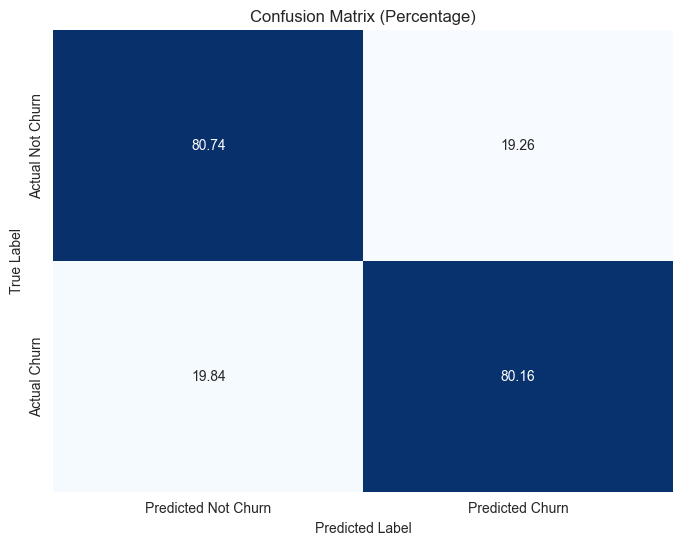

Metrics for each fold:

Fold 1:
  Accuracy: 0.8151
  Precision: 0.8554
  Recall: 0.8151
  F1 Score: 0.8266

Fold 2:
  Accuracy: 0.8115
  Precision: 0.8509
  Recall: 0.8115
  F1 Score: 0.8231

Fold 3:
  Accuracy: 0.8080
  Precision: 0.8512
  Recall: 0.8080
  F1 Score: 0.8203

Fold 4:
  Accuracy: 0.8085
  Precision: 0.8524
  Recall: 0.8085
  F1 Score: 0.8209

Fold 5:
  Accuracy: 0.8053
  Precision: 0.8491
  Recall: 0.8053
  F1 Score: 0.8179

Mean metrics across all folds:
Accuracy: 0.8097
Precision: 0.8518
Recall: 0.8097
F1 Score: 0.8217


In [12]:
feature_selector = SelectFromModel(RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42))

model = imbpipeline([
    ('preprocessor', preprocessor),
    ('undersampler', undersampler),
    # ('feature_selection', feature_selector),  
    ('classifier', RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42))  
])

model.fit(X_train, y_train)

evaluate_model(model, X_test, y_test)

perform_x_validation(model)

# lightgbm

[LightGBM] [Info] Number of positive: 27966, number of negative: 27966
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000981 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 861
[LightGBM] [Info] Number of data points in the train set: 55932, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Accuracy: 0.8091010997667162
              precision    recall  f1-score   support

           0       0.94      0.81      0.87     26052
           1       0.53      0.79      0.64      6955

    accuracy                           0.81     33007
   macro avg       0.73      0.80      0.75     33007
weighted avg       0.85      0.81      0.82     33007

Precision: 0.5314
Recall: 0.7947
F1 Score: 0.6369
AUC: 0.8891


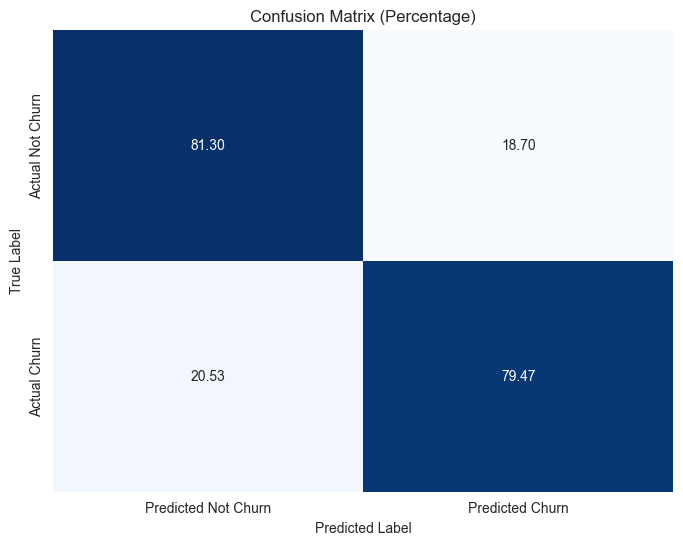

[LightGBM] [Info] Number of positive: 22373, number of negative: 22373
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001850 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 862
[LightGBM] [Info] Number of data points in the train set: 44746, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 22372, number of negative: 22372
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000770 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 862
[LightGBM] [Info] Number of data points in the train set: 44744, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 22373, number of negat

In [13]:
# resampler = SMOTEENN(random_state=42)
undersampler = RandomUnderSampler(random_state=42)
feature_selector = SelectFromModel(LGBMClassifier(n_estimators=200, max_depth=10, random_state=42))

model = imbpipeline([
    ('preprocessor', preprocessor),
    # ('resampler', resampler),  
    ('undersampler', undersampler),
    # ('feature_selection', feature_selector),  
    ('classifier', LGBMClassifier(n_estimators=200, max_depth=10, random_state=42))  
])

model.fit(X_train, y_train)

evaluate_model(model, X_test, y_test)

perform_x_validation(model)

# xgboost

Accuracy: 0.7844093677098797
              precision    recall  f1-score   support

           0       0.93      0.78      0.85     26052
           1       0.49      0.78      0.60      6955

    accuracy                           0.78     33007
   macro avg       0.71      0.78      0.73     33007
weighted avg       0.84      0.78      0.80     33007

Precision: 0.4927
Recall: 0.7823
F1 Score: 0.6046
AUC: 0.8668


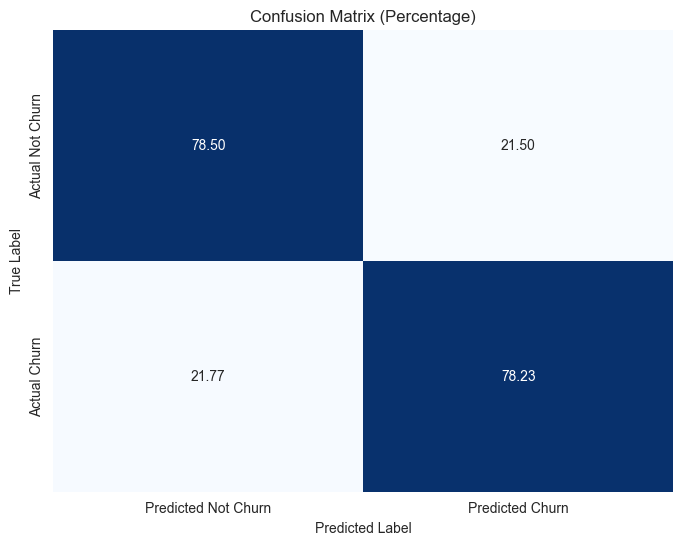

Metrics for each fold:

Fold 1:
  Accuracy: 0.7878
  Precision: 0.8391
  Recall: 0.7878
  F1 Score: 0.8024

Fold 2:
  Accuracy: 0.7847
  Precision: 0.8381
  Recall: 0.7847
  F1 Score: 0.7998

Fold 3:
  Accuracy: 0.7805
  Precision: 0.8351
  Recall: 0.7805
  F1 Score: 0.7960

Fold 4:
  Accuracy: 0.7867
  Precision: 0.8389
  Recall: 0.7867
  F1 Score: 0.8015

Fold 5:
  Accuracy: 0.7874
  Precision: 0.8370
  Recall: 0.7874
  F1 Score: 0.8018

Mean metrics across all folds:
Accuracy: 0.7854
Precision: 0.8376
Recall: 0.7854
F1 Score: 0.8003


In [14]:
resampler = SMOTEENN(random_state=42)
undersampler = RandomUnderSampler(random_state=42)
feature_selector = SelectFromModel(XGBClassifier(n_estimators=200, max_depth=10, random_state=42))

model = imbpipeline([
    ('preprocessor', preprocessor),
    # ('resampler', resampler),  
    ('undersampler', undersampler),
    # ('feature_selection', feature_selector),  
    ('classifier', XGBClassifier(n_estimators=200, max_depth=10, random_state=42,))  
])

model.fit(X_train, y_train)

evaluate_model(model, X_test, y_test)

perform_x_validation(model)

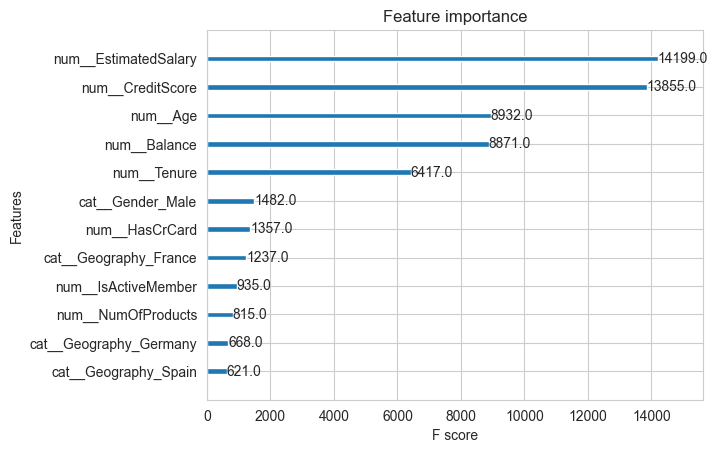

In [15]:
feature_names = model.named_steps['preprocessor'].get_feature_names_out()

if 'feature_selection' in model.named_steps:
    selected_features_indices = model.named_steps['feature_selection'].get_support(indices=True)
    selected_feature_names = feature_names[selected_features_indices]
else:
    selected_feature_names = feature_names

xgb_clf = model.named_steps['classifier']
booster = xgb_clf.get_booster()
booster.feature_names = selected_feature_names.tolist()

xgb.plot_importance(booster, max_num_features=20)
plt.show()

# model selection

used random forest here since it performs the best with default parameters

- Accuracy: 0.8061623292028963
- Precision: 0.5263
- Recall: 0.8016
- F1 Score: 0.6354
- AUC: 0.8874